# Spacetime Indicatrix

In [1]:
#JAX
import jax.numpy as jnp
import jax.random as jran
from jax import vmap
from jax import random as jran


#Scipy
from scipy.ndimage.filters import gaussian_filter

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.ticker as tkr

#celluloid
from celluloid import Camera # getting the camera

#IPython.display
from IPython.display import HTML # to show the animation in Jupyter

#jaxgeometry
from jaxgeometry.manifolds import LorentzSpacetime
from jaxgeometry.setup import dts

/tmp/ipykernel_61591/3568392642.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
2023-11-13 16:40:07.859747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Define File Paths

In [2]:
figure_path = 'Figures/spacetime_indicatrix/'

In [3]:
#hyper-parameters
T = 1.0
N_grid = 100
start = -2.0
end = 2.0

In [4]:
#Plotting
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Defining Manifold

In [5]:
mua_fun = lambda x: (1+x[0][0]+x[0][1]**2+x[0][2]**2)*0.5/((1+x[0][0])**2)
mub_fun = lambda x: (1+x[0][0]+x[0][1]**2+x[0][2]**2)*0.5/((1+x[0][0])**2)
mutheta_fun = lambda x: jnp.zeros(1, dtype=jnp.float32)

sigmaa_fun = lambda x: 0.1*(1-jnp.exp(-(x[0][1]+x[0][0])**4))#jnp.exp(-(x[0][1]+x[0][2]+t)**4)
sigmab_fun = lambda x: 0.1*(1-jnp.exp(-(x[0][2]+x[0][0])**4))#jnp.exp(-(x[0][1]+x[0][2]+t)**4)
sigmatheta_fun = lambda x: jnp.zeros(1, dtype=jnp.float32)

In [6]:
def G(x, eps=jnp.zeros(3)):
    
    theta = mutheta_fun(x)+eps[0]*sigmatheta_fun(x)
    a2 = (mua_fun(x)+eps[1]*sigmaa_fun(x))**2
    b2 = (mub_fun(x)+eps[2]*sigmab_fun(x))**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)

    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]]).squeeze()/(a2*b2)

In [7]:
M = LorentzSpacetime(g=G,
                    N=2)

using M.Exp for Logarithm


## Defining grid

In [8]:
t_grid = jnp.linspace(0,1,N_grid)
x1_grid = jnp.linspace(start,end,N_grid)
x2_grid = jnp.linspace(start,end,N_grid)
X1_grid, X2_grid = jnp.meshgrid(x1_grid,x2_grid)
X_grid = jnp.concatenate((X1_grid.reshape(N_grid, N_grid, 1), 
                          X2_grid.reshape(N_grid, N_grid, 1)), axis=-1)


N_plot = 10
t_plot = jnp.linspace(0,1,N_plot)
x1_plot = jnp.linspace(start,end,N_plot)
x2_plot = jnp.linspace(start,end,N_plot)
X1_plot, X2_plot = jnp.meshgrid(x1_plot,x2_plot)
X_plot = jnp.concatenate((X1_plot.reshape(N_plot, N_plot, 1), 
                          X2_plot.reshape(N_plot, N_plot, 1)), axis=-1)

### Computing the Metric

In [97]:
def volume_measure(x):
    
    return jnp.sqrt(jnp.linalg.det(M.g((x, jnp.zeros(1)))))

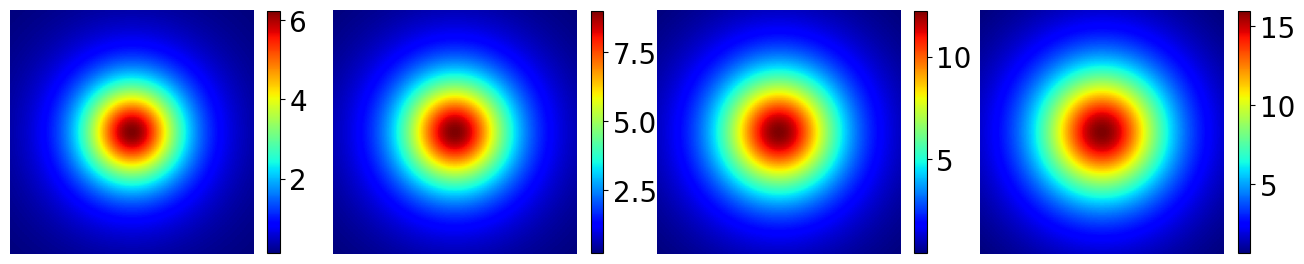

In [98]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
g = vmap(lambda t: vmap(lambda y: vmap(lambda x: volume_measure(jnp.concatenate((jnp.array([t]),x))))(y))(X_grid))(jnp.array([0.25,0.5,0.75,1.0]))
extent = [start, end, start, end]
fig = plt.figure(figsize=(16,4))
for k in range(4):
    ax = fig.add_subplot(1,4,k+1)
    ax.imshow(g[k].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    #ax.set_title(f"Riemannian Volume Measure for T={T:.1f}")
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(g[k])
    fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
    ax.set_box_aspect(1.0)
    ax.set_axis_off()

plt.show()
fig.savefig(figure_path+'lm_volume.pdf', format="pdf", bbox_inches="tight")

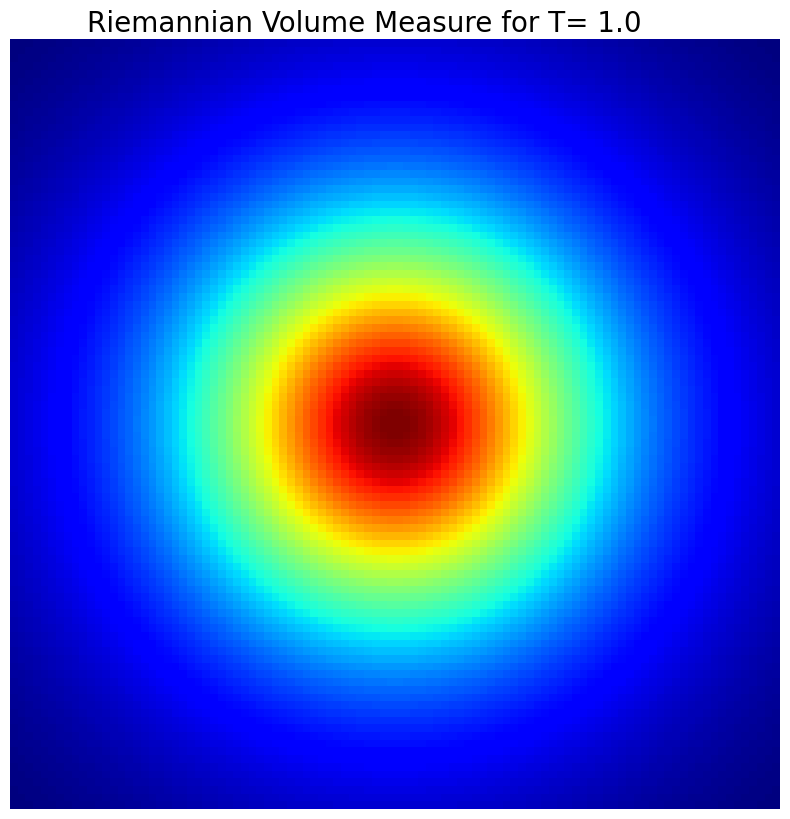

In [99]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
g = vmap(lambda t: vmap(lambda y: vmap(lambda x: \
                                       volume_measure(jnp.concatenate((jnp.array([t]),x))))(y))(X_grid))(t_plot)
extent = [start, end, start, end]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
for i in range(len(t_plot)):
    ax.imshow(g[i].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    ax.text(0.1, 1.01, f"Riemannian Volume Measure for T= {t_plot[i]:.1f}", transform=ax.transAxes)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(g[i])
    #fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
    
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'lm_volume.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation

    #plt.show()
    #fig.savefig(figure_path+'volume'+str(t_val[i]).replace('.','_')+'.pdf', format="pdf", bbox_inches="tight")

### IVP Geodesics

In [100]:
def M_geodesic():
    
    dt = dts(n_steps=100)
    
    N_spray = 100
    p0 = (jnp.concatenate((jnp.zeros(1), jnp.zeros(2)+0.5)), jnp.zeros(1))
    phi = jnp.linspace(0, 2*jnp.pi,N_spray)
    v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T
    v = vmap(lambda w: w/jnp.sqrt(w.dot(G((p0[0][1:], p0[1])).dot(w))))(v)

    v = jnp.concatenate((jnp.ones(N_spray).reshape(1,-1), v.T)).T
    
    time_grid, gamma, gamma_chart = vmap(lambda v: M.geodesic(p0, v, dt))(v)
    
    return time_grid, gamma[:,:,0], gamma_chart, gamma[:,:,1]

time_grid, rm_gamma, gamma_chart, gamma_v = M_geodesic()

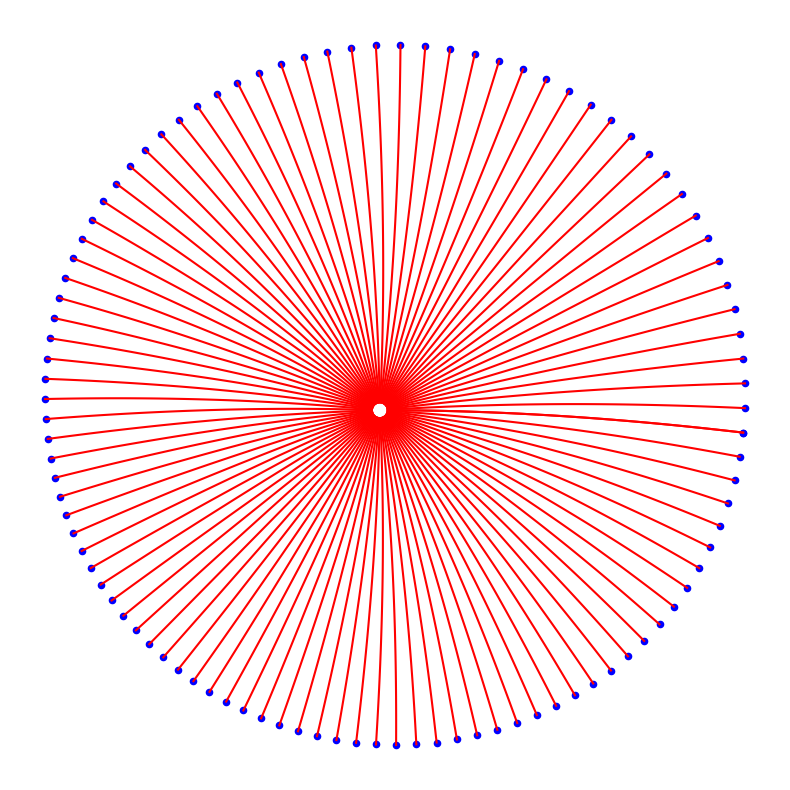

In [101]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rm_gamma[:,:,1].T, rm_gamma[:,:,2].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
#ax.set_title(f"Geodesic Spray for T={T:.1f}")
ax.scatter(rm_gamma[:,-1,1], rm_gamma[:,-1,2], color='blue', s=20)
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
fig.savefig(figure_path+'lm_ivp2d.pdf', format="pdf", bbox_inches="tight")

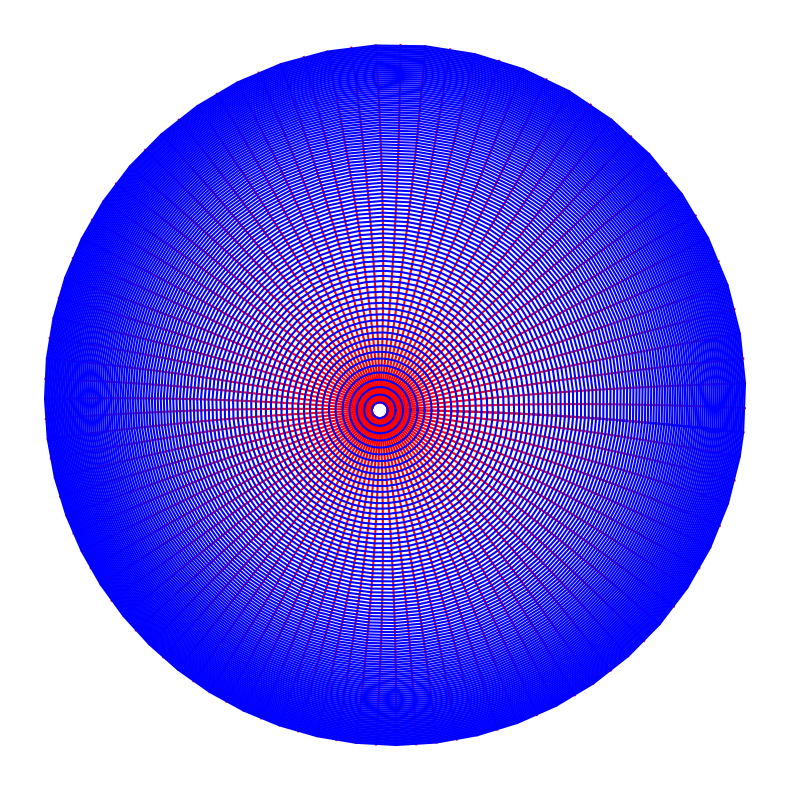

In [102]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
rm_gamma_circle = jnp.concatenate((rm_gamma, 
                                   rm_gamma[0].reshape(1,rm_gamma.shape[1], 
                                                          rm_gamma.shape[2])))
ax.plot(rm_gamma[:,:,1].T, rm_gamma[:,:,2].T, color='red')
ax.plot(rm_gamma_circle[:,:,1][::2], rm_gamma_circle[:,:,2][::2], color='blue')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
#ax.set_title(f"IVP Geodesics for T={T:.1f}")
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
fig.savefig(figure_path+'lrm_ivp2d_circle.pdf', format="pdf", bbox_inches="tight")

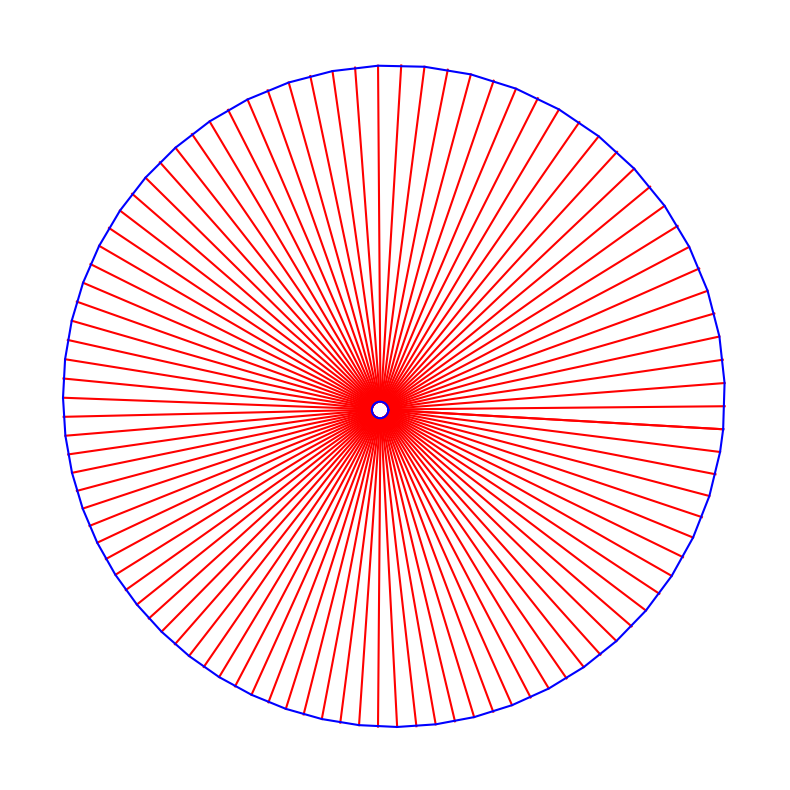

In [103]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
for i in range(1,9):
    ax.plot(rm_gamma[:,::(i*10),1].T, rm_gamma[:,::(i*10),2].T, color='red')
    ax.plot(rm_gamma_circle[:,::(i*10),1][::2], rm_gamma_circle[:,::(i*10),2][::2], color='blue')
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'rm_2divp.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation

### Sectional Curvature

In [104]:
def sec_curvature(x):
    
    e1 = jnp.array([0.0,1.0, 0.0])
    e2 = jnp.array([0.0,0.0, 1.0])
    
    return M.SectionalCurvature(x, e1, e2)

In [105]:
N_grid = 100
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda x: vmap(lambda y: sec_curvature((jnp.concatenate((jnp.ones(1),
                                                                    y)),
                                                   jnp.zeros(1))))(x))(X)

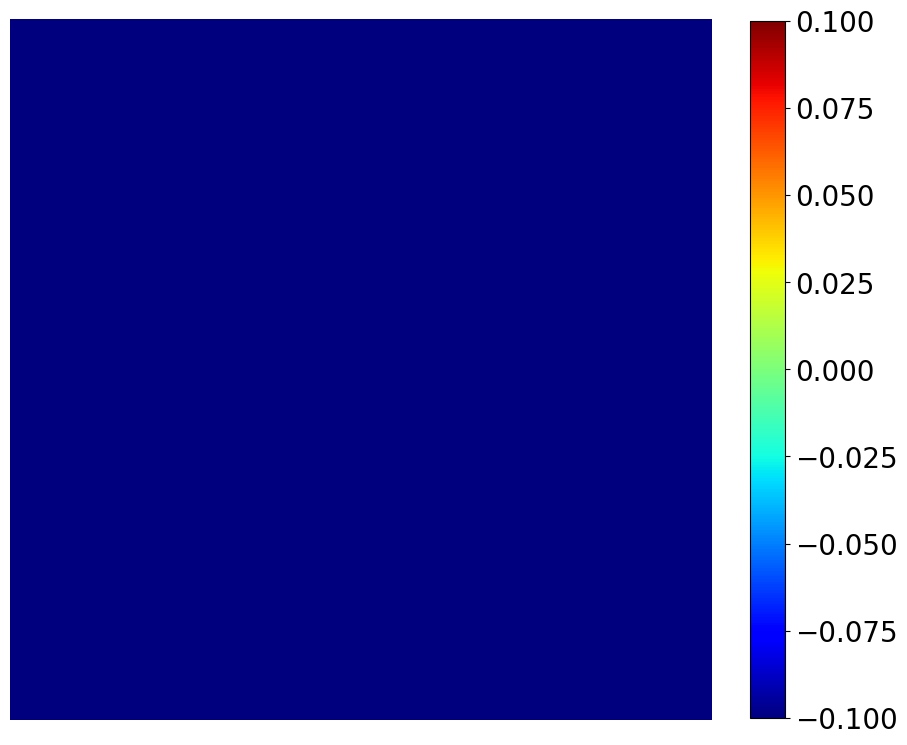

In [106]:
fig = plt.figure(figsize=(10,10))
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec
extent = [-2.0, 2.0, -2.0, 2.0]
ax = fig.add_subplot(111)
ax.imshow(sec.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
#ax.set_title(f"Sectional Curvature for T={T:.1f}")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(sec[k])
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

fig.savefig(figure_path+'lm_curvature.pdf', format="pdf", bbox_inches="tight")

## Stochastic Pertubations

In [107]:
N_sim = 100
key = jran.PRNGKey(2712)
eps = jran.normal(key, shape=(N_sim, 3))

### Computing the Metric

In [108]:
def volume_measure(x, eps):
    
    M = LorentzSpacetime(g=lambda x: G(x,eps),
                    N=2)
    
    return jnp.sqrt(jnp.linalg.det(M.g((x, jnp.zeros(1)))))

g = vmap(lambda e: vmap(lambda y: vmap(lambda x: volume_measure(jnp.concatenate((jnp.ones(1),x)),e))(y))(X_grid))(eps)

using M.Exp for Logarithm


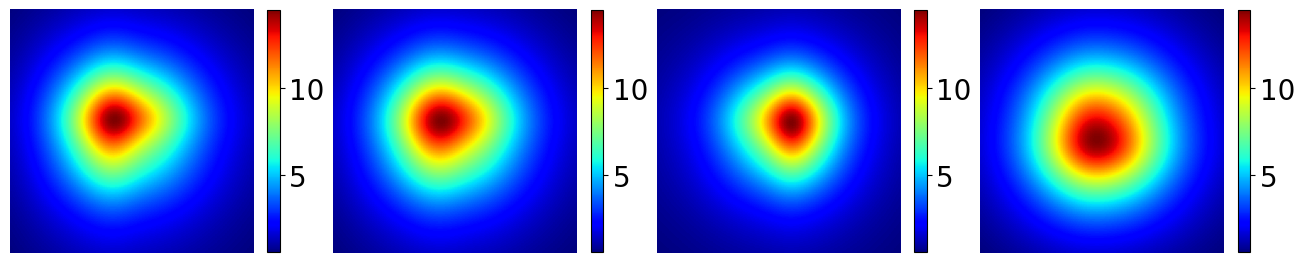

In [109]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]

fig = plt.figure(figsize=(16,4))
extent = [start, end, start, end]
for k in range(4):
    ax = fig.add_subplot(1,4,k+1)
    ax.imshow(g[k].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    #ax.set_title("Riemannian Volume Measure for T={T:.1f}")
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(g[i])
    fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
    ax.set_box_aspect(1.0)
    ax.set_axis_off()
    

plt.show()
fig.savefig(figure_path+'slm_volume.pdf', format="pdf", bbox_inches="tight")

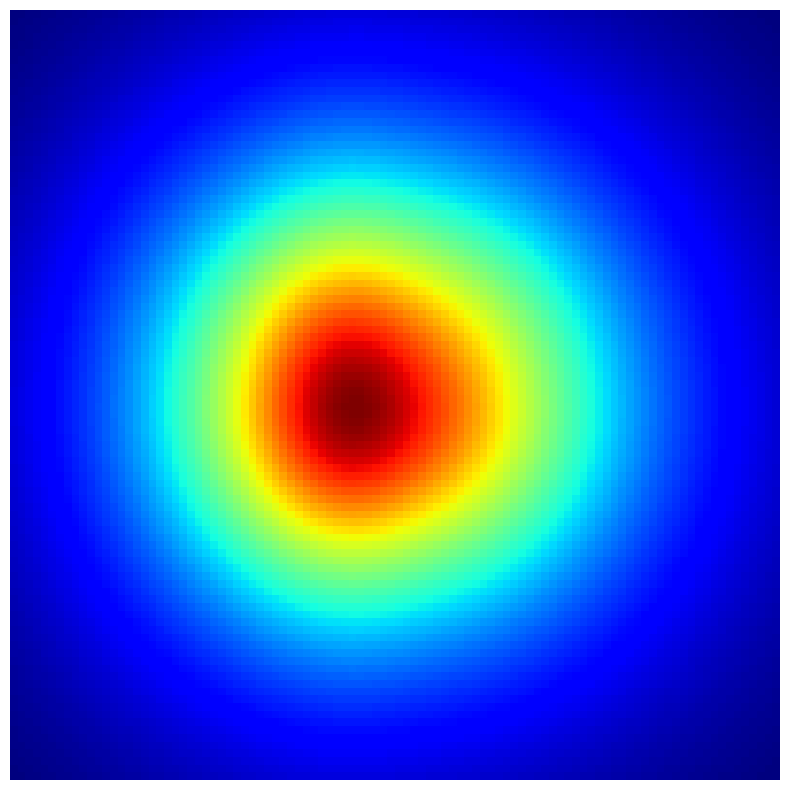

In [110]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
extent = [start, end, start, end]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
for i in range(len(eps[:10])):
    ax.imshow(g[i].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(g[i])
    #fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
    
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'srm_volume.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation

    #plt.show()
    #fig.savefig(figure_path+'volume'+str(t_val[i]).replace('.','_')+'.pdf', format="pdf", bbox_inches="tight")

### IVP Geodesics

In [111]:
def M_geodesic(eps):
    
    M = LorentzSpacetime(g=lambda x: G(x,eps),
                    N=2)
    
    dt = dts(n_steps=100)
    
    N_spray = 100
    p0 = (jnp.concatenate((jnp.zeros(1), jnp.zeros(2)+0.5)), jnp.zeros(1))
    phi = jnp.linspace(0, 2*jnp.pi,N_spray)
    v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T
    v = vmap(lambda w: w/jnp.sqrt(w.dot(G((p0[0][1:], p0[1])).dot(w))))(v)

    v = jnp.concatenate((jnp.ones(N_spray).reshape(1,-1), v.T)).T
    
    time_grid, gamma, gamma_chart = vmap(lambda v: M.geodesic(p0, v, dt))(v)
    
    return time_grid, gamma[:,:,0], gamma_chart, gamma[:,:,1]

time_grid, rm_gamma, gamma_chart, gamma_v = vmap(lambda e: M_geodesic(e))(eps)

using M.Exp for Logarithm


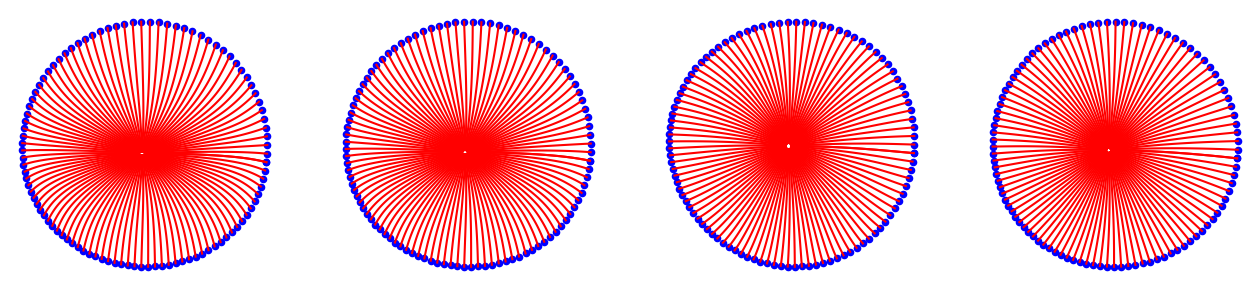

In [112]:
fig = plt.figure(figsize=(16,4))
for k in range(4):
    ax = fig.add_subplot(1,4,k+1)
    ax.plot(rm_gamma[k][:,:,1].T, rm_gamma[k][:,:,2].T, color='red')
    ax.set_xlabel("$x^{1}$")
    ax.set_ylabel("$x^{2}$")
    #ax.set_title(f"Geodesic Spray for T={T:.1f}")
    ax.scatter(rm_gamma[k][:,-1,1], rm_gamma[k][:,-1,2], color='blue', s=20)
    ax.grid()
    ax.set_box_aspect(1.0)
    ax.set_axis_off()
fig.savefig(figure_path+'slm_ivp2d.pdf', format="pdf", bbox_inches="tight")

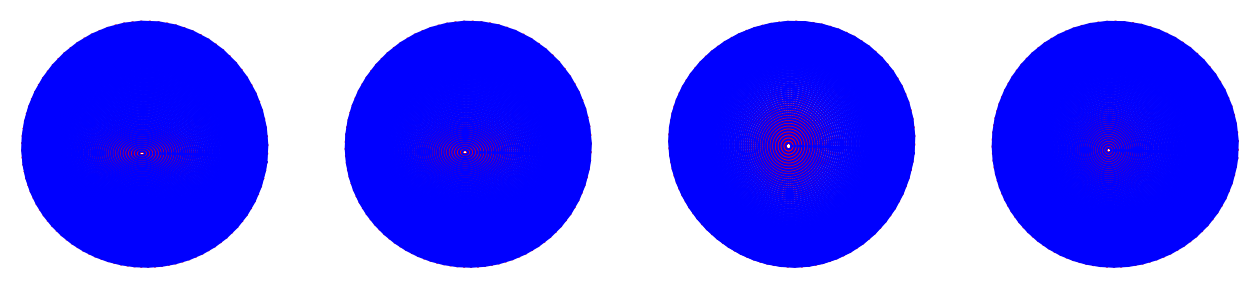

In [113]:
fig = plt.figure(figsize=(16,4))
for k in range(4):
    ax = fig.add_subplot(1,4,k+1)
    rm_gamma_circle = jnp.concatenate((rm_gamma[k], 
                                       rm_gamma[k][0].reshape(1,rm_gamma[k].shape[1], 
                                                              rm_gamma[k].shape[2])))
    ax.plot(rm_gamma[k][:,:,1].T, rm_gamma[k][:,:,2].T, color='red')
    ax.plot(rm_gamma_circle[:,:,1][::2], rm_gamma_circle[:,:,2][::2], color='blue')
    ax.set_xlabel("$x^{1}$")
    ax.set_ylabel("$x^{2}$")
    #ax.set_title(f"IVP Geodesics for T={T:.1f}")
    ax.grid()
    ax.set_box_aspect(1.0)
    ax.set_axis_off()
fig.savefig(figure_path+'slm_ivp2d_circle.pdf', format="pdf", bbox_inches="tight")

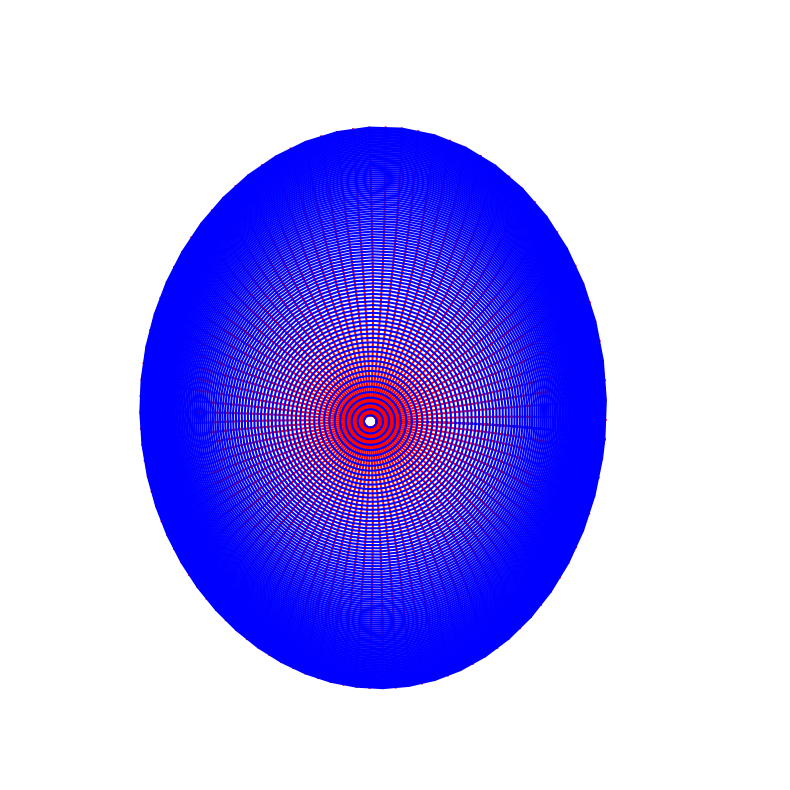

In [114]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
for k in range(11):
    rm_gamma_circle = jnp.concatenate((rm_gamma[k], 
                                       rm_gamma[k][0].reshape(1,rm_gamma[k].shape[1], 
                                                              rm_gamma[k].shape[2])))
    ax.plot(rm_gamma[k][:,:,1].T, rm_gamma[k][:,:,2].T, color='red')
    ax.plot(rm_gamma_circle[:,:,1][::2], rm_gamma_circle[:,:,2][::2], color='blue')
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'slm_2divp.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation

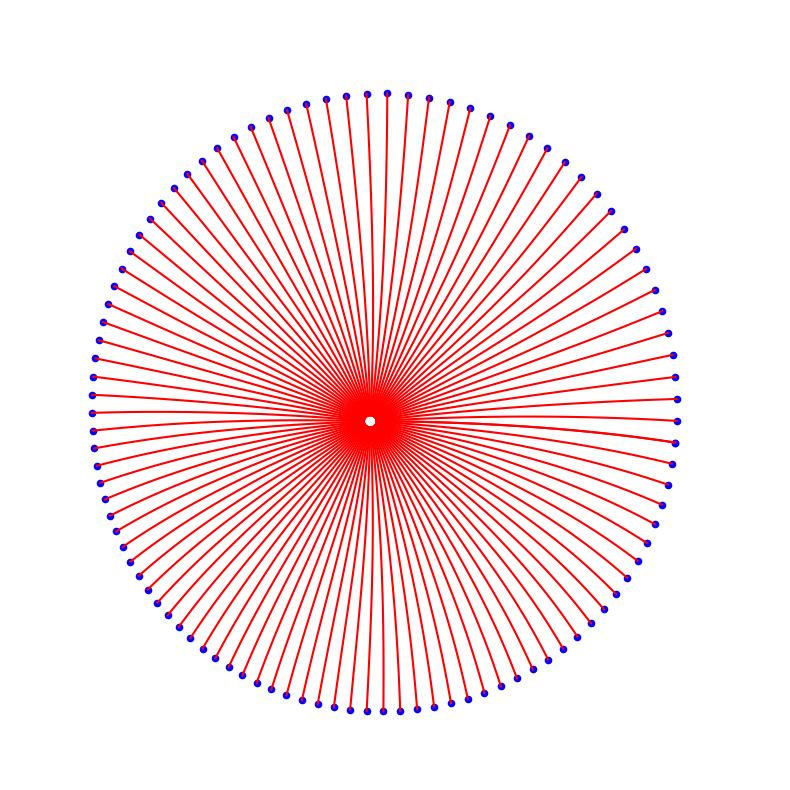

In [115]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
for k in range(10):
    ax.plot(rm_gamma[k][:,:,1].T, rm_gamma[k][:,:,2].T, color='red')
    ax.scatter(rm_gamma[k][:,-1,1], rm_gamma[k][:,-1,2], color='blue', s=20)
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'slm_2divp.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation


### Sectional Curvature

In [116]:
def sec_curvature(eps):
    
    M = LorentzSpacetime(g=lambda x: G(x,eps),
                    N=2)
    
    e1 = jnp.array([0.0,1.0, 0.0])
    e2 = jnp.array([0.0,0.0, 1.0])
        
    return vmap(lambda x: vmap(lambda y: M.SectionalCurvature((jnp.concatenate((jnp.zeros(1),
                                                                                y)),jnp.zeros(1)), e1, e2))(x))(X)

N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda e: sec_curvature(e))(eps)

using M.Exp for Logarithm


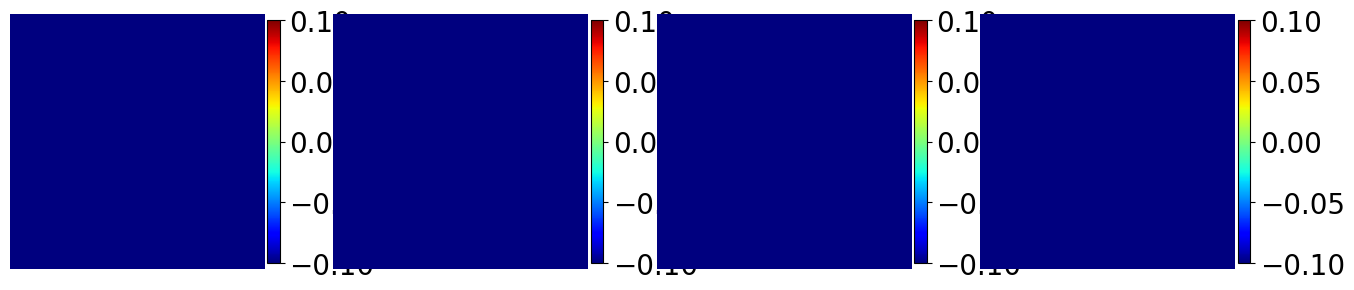

In [117]:
fig = plt.figure(figsize=(16,4))
for k in range(4):    
    ax = fig.add_subplot(1,4,k+1)
    #heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
    #heatmap = gaussian_filter(sec, sigma=1.0)
    #heatmap /= jnp.linalg.norm(heatmap)
    heatmap = sec[k]
    extent = [-2.0, 2.0, -2.0, 2.0]
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([-2.0, 2.0])
    ax.set_ylim([-2.0, 2.0])
    #ax.set_title("Sectional Curvature")
    ax.set_xlabel("$x^{1}$")
    ax.set_ylabel("$x^{2}$")
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(heatmap.T)
    fig.colorbar(m, ax=ax, fraction=0.045, pad=0.01)
    
    ax.set_box_aspect(1.0)
    ax.set_axis_off()

plt.show()

fig.savefig(figure_path+'slm_curvature.pdf', format="pdf", bbox_inches="tight")    

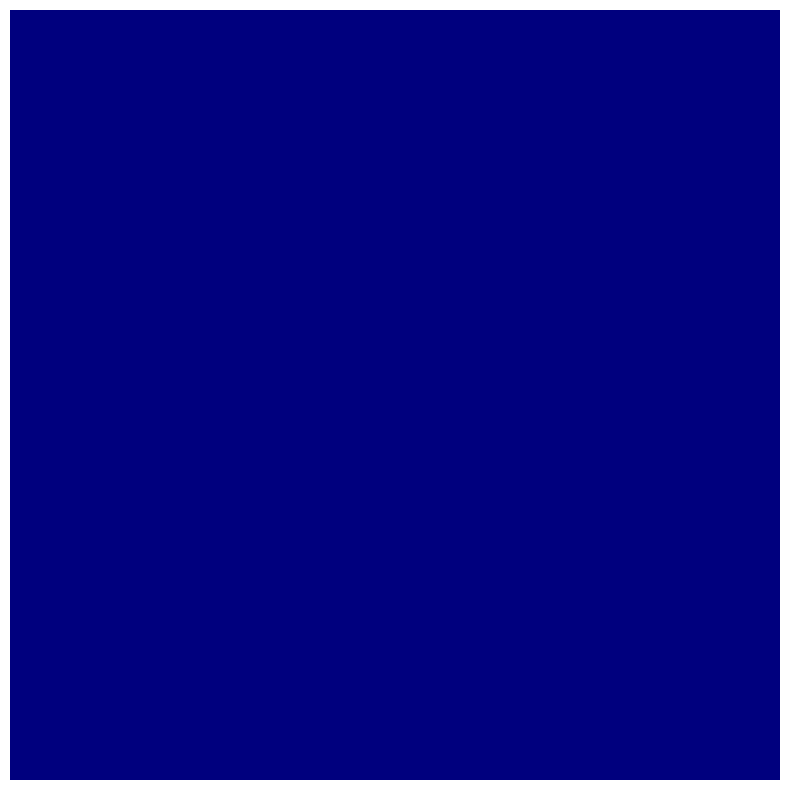

In [118]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
for k in range(10):
    ax.imshow(sec[k].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([-2.0, 2.0])
    ax.set_ylim([-2.0, 2.0])
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'slm_curvature.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation


## Frozen Metric

In [9]:
#Source: https://github.com/google/jax/discussions/10689
from jax import jit

#@jit
def bispline_interp(xnew,ynew,xp,yp,zp):
    """
    (xnew,ynew): two 1D vector  of same size where to perform predictions  f(xnew[i],ynew[i])
    (xp,yp): original grid points 1D vector
    zp: original values of functions  zp[i,j] = value at xp[i], yp[j]
    """
    
    
    M = 1./16 * jnp.array([[0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, -8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, 16, -40, 32, -8, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, -8, 24, -24, 8, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, -8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0], 
                           [4, 0, -4, 0, 0, 0, 0, 0, -4, 0, 4, 0, 0, 0, 0, 0], 
                           [-8, 20, -16, 4, 0, 0, 0, 0, 8, -20, 16, -4, 0, 0, 0, 0],
                           [4, -12, 12, -4, 0, 0, 0, 0, -4, 12, -12, 4, 0, 0, 0, 0],
                           [0, 16, 0, 0, 0, -40, 0, 0, 0, 32, 0, 0, 0, -8, 0, 0], 
                           [-8, 0, 8, 0, 20, 0, -20, 0, -16, 0, 16, 0, 4, 0, -4, 0], 
                           [16, -40, 32, -8, -40, 100, -80, 20, 32, -80, 64, -16, -8, 20, -16, 4], 
                           [-8, 24, -24, 8, 20, -60, 60, -20, -16, 48, -48, 16, 4, -12, 12, -4], 
                           [0, -8, 0, 0, 0, 24, 0, 0, 0, -24, 0, 0, 0, 8, 0, 0], 
                           [4, 0, -4, 0, -12, 0, 12, 0, 12, 0, -12, 0, -4, 0, 4, 0], 
                           [-8, 20, -16, 4, 24, -60, 48, -12, -24, 60, -48, 12, 8, -20, 16, -4], 
                           [4, -12, 12, -4, -12, 36, -36, 12, 12, -36, 36, -12, -4, 12, -12, 4]]
                         )
    
    M1 = jnp.array([[1.,0.,0.,0.],
                    [-1.,1.,0.,0.],
                    [-1.,0.,1.,0.],
                    [1.,-1.,-1.,1.]])

    def built_Ivec(zp,idx):
        return jnp.array([zp[idx+i+j] for j in range(-1,3) for i in range(-1,3)])


    def built_Ivec1(zp,idx):
        return jnp.array([zp[idx+i+j] for j in range(0,2) for i in range(0,2)])
    
    def compute_basis(x,order=3):
        """
        x in [0,1]
        """ 
        return jnp.array([x**i for i in jnp.arange(0, order+1)])
    
    def tval(xnew,idx,xp):
        return (xnew-xp[idx-1])/(xp[idx]-xp[idx-1])
    
    def bilinear_interp(idx):
        Iv = built_Ivec1(zp,idx-1-1)
        av = M1 @ Iv
        amtx = av.reshape(2,2,-1)
        tx = tval(xnew,idx,xp)
        ty = tval(ynew,idx,yp)
        basis_x = compute_basis(tx,order=1)
        basis_y = compute_basis(ty,order=1)
        res = jnp.einsum("i...,ij...,j...",basis_y,amtx,basis_x)
        return res

    def bispline_interp(idx):
        Iv = built_Ivec(zp,idx-1-1)
        av = M @ Iv
        amtx = av.reshape(4,4,-1)
        tx = tval(xnew,idx,xp)
        ty = tval(ynew,idx,yp)
        basis_x = compute_basis(tx)
        basis_y = compute_basis(ty)
        res = jnp.einsum("i...,ij...,j...",basis_y,amtx,basis_x)
        return res
    
    idx_sort = xp.argsort()
    xp = xp[idx_sort]
    yp = yp[idx_sort]
    zp = zp[idx_sort]
    
    val_x = jnp.abs(xp-xnew)
    val_x = jnp.abs(jnp.min(val_x)-val_x)
    idx_x = jnp.where(val_x<1e-8, jnp.arange(val_x.shape[0]), val_x.shape[0])
    
    val_y = jnp.concatenate((jnp.abs(yp-ynew), jnp.ones(1)*jnp.max(yp)))[idx_x]
    idx = jnp.argmin(val_y)
    
    cond = jnp.logical_and(idx>=2, idx<=len(xp)-2)

    return jnp.where(cond,
             bispline_interp(idx),
             bilinear_interp(idx))

In [11]:
def time_fun(x):
    
    return bispline_interp(x[0], x[1], wavefront_x1grid, wavefront_x2grid, 
                   wavefront_tgrid)

In [30]:
def M_geodesic():
    
    dt = dts(n_steps=100)
    
    N_spray = 100
    p0 = (jnp.concatenate((jnp.zeros(1), jnp.zeros(2)+0.5)), jnp.zeros(1))
    phi = jnp.linspace(0, 2*jnp.pi,N_spray)
    v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T
    v = vmap(lambda w: w/jnp.sqrt(w.dot(G((p0[0][1:], p0[1])).dot(w))))(v)

    v = jnp.concatenate((jnp.ones(N_spray).reshape(1,-1), v.T)).T
    
    time_grid, gamma, gamma_chart = vmap(lambda v: M.geodesic(p0, v, dt))(v)
    
    return time_grid, gamma[:,:,0], gamma_chart, gamma[:,:,1]

time_grid, rm_gamma, gamma_chart, gamma_v = M_geodesic()

In [31]:
wavefront_xgrid = rm_gamma.reshape(-1,3)
wavefront_tgrid = wavefront_xgrid[:,0]
wavefront_x1grid = wavefront_xgrid[:,1]
wavefront_x2grid = wavefront_xgrid[:,2]

In [32]:
N_grid = 100
x1 = jnp.linspace(jnp.min(wavefront_x1grid), jnp.max(wavefront_x1grid), N_grid)
x2 = jnp.linspace(jnp.min(wavefront_x2grid), jnp.max(wavefront_x2grid), N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
time_fun_grid = (vmap(lambda x: vmap(lambda y: time_fun(y))(x))(X)).squeeze()

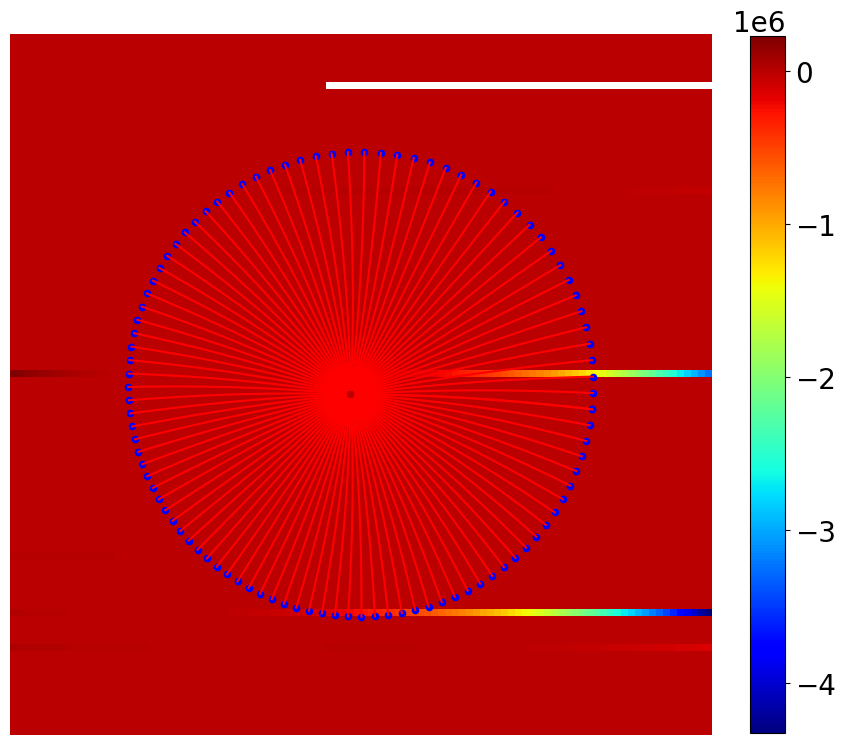

In [38]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
extent = [jnp.min(rm_gamma[:,:,1])-0.1, jnp.max(rm_gamma[:,:,1])+0.1, 
          jnp.min(rm_gamma[:,:,2])-0.1, jnp.max(rm_gamma[:,:,2])+0.1]
ax.plot(rm_gamma[:,:,1].T, rm_gamma[:,:,2].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
#ax.set_title(f"Geodesic Spray for T={T:.1f}")
ax.scatter(rm_gamma[:,-1,1], rm_gamma[:,-1,2], color='blue', s=20)
ax.imshow(time_fun_grid.T, extent=extent, origin='lower', cmap=cm.jet)
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(time_fun_grid)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
fig.savefig(figure_path+'lm_time_func.pdf', format="pdf", bbox_inches="tight")

In [36]:
time_fun_grid_removed = time_fun_grid.at[jnp.abs(time_fun_grid) > 100].set(jnp.nan)

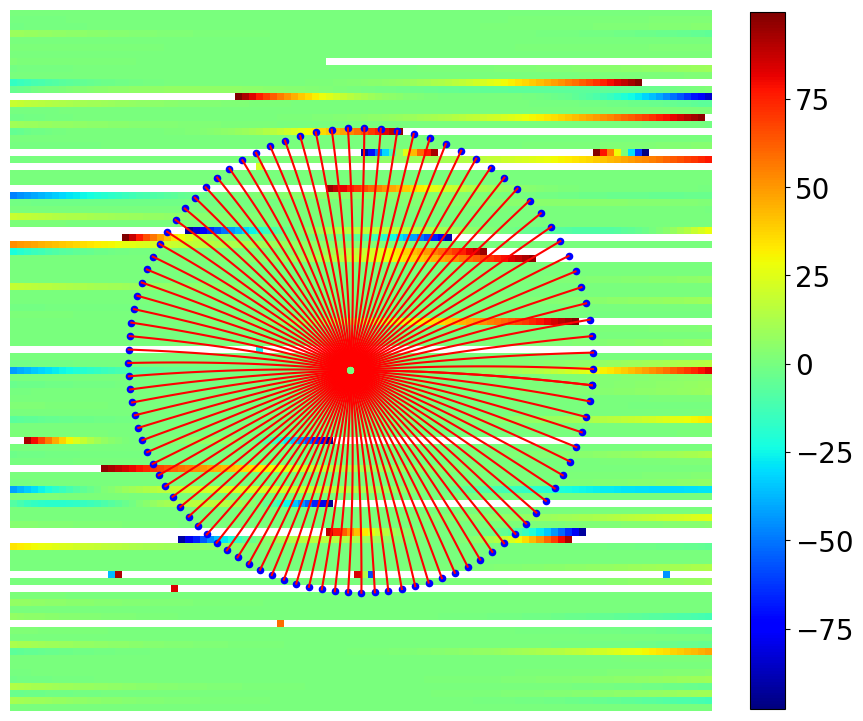

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
extent = [jnp.min(rm_gamma[:,:,1])-0.1, jnp.max(rm_gamma[:,:,1])+0.1, 
          jnp.min(rm_gamma[:,:,2])-0.1, jnp.max(rm_gamma[:,:,2])+0.1]
ax.plot(rm_gamma[:,:,1].T, rm_gamma[:,:,2].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
#ax.set_title(f"Geodesic Spray for T={T:.1f}")
ax.scatter(rm_gamma[:,-1,1], rm_gamma[:,-1,2], color='blue', s=20)
ax.imshow(time_fun_grid_removed.T, extent=extent, origin='lower', cmap=cm.jet)
ax.grid()
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(time_fun_grid_removed)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
fig.savefig(figure_path+'lm_time_func_rest.pdf', format="pdf", bbox_inches="tight")